In [1]:

import torch.utils.data as data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import access_br_dwgd as access_br_dwgd
import seaborn as sns
import sys, os
sys.path.append(os.path.abspath(".."))

import utils.lstm as lstm
from utils.logger import Logger
logger = Logger.configurar_logger(nome_arquivo="randomForestBRDWGD.log", nome_classe="randomForest BRDWGD")
logger.info("Iniciando script de previsão com randomForest BRDWGD.")


2025-10-13 22:12:07.727190: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-13 22:12:08,877 - randomForest BRDWGD - INFO - Iniciando script de previsão com randomForest BRDWGD.


2025-10-13 22:12:11,549 - randomForest BRDWGD - INFO - Dados carregados com sucesso. Total de 14580 registros.


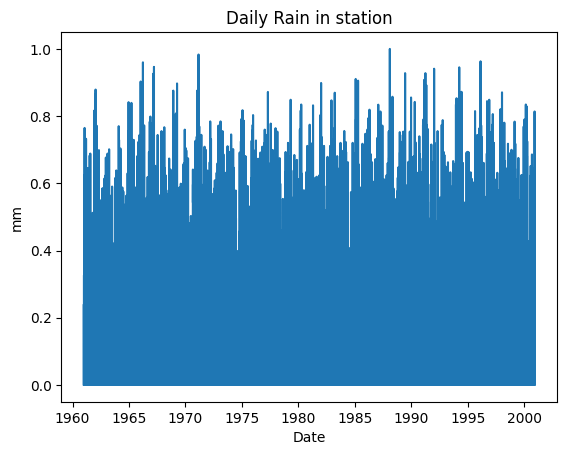

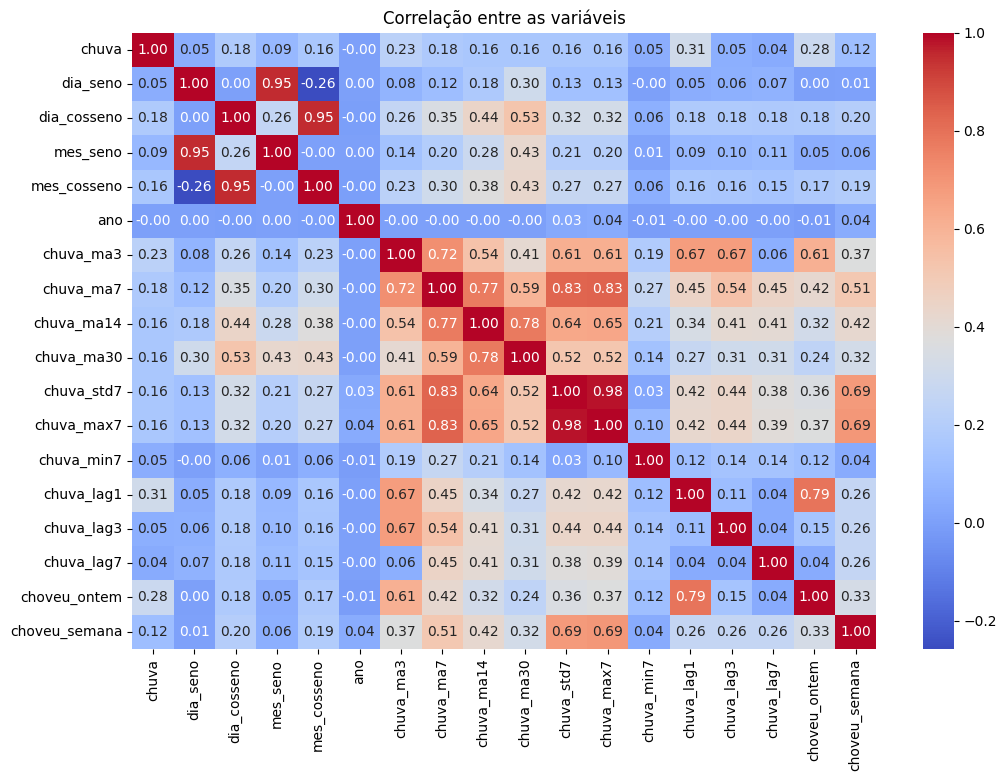

In [2]:
timeseries = access_br_dwgd.recuperar_dados_br_dwgd_com_area()
timeseries = timeseries.to_frame(name='chuva')
timeseries['chuva'] = np.log1p(timeseries['chuva'])

num_features = 18
# 2. FEATURES TEMPORAIS
timeseries['dia_seno'] = np.sin(2 * np.pi * timeseries.index.dayofyear / 365)
timeseries['dia_cosseno'] = np.cos(2 * np.pi * timeseries.index.dayofyear / 365)
timeseries['mes_seno'] = np.sin(2 * np.pi * timeseries.index.month / 12)
timeseries['mes_cosseno'] = np.cos(2 * np.pi * timeseries.index.month / 12)
timeseries['ano'] = timeseries.index.year - timeseries.index.year.min()


timeseries['chuva_ma3']  = timeseries['chuva'].shift(1).rolling(window=3, min_periods=1).mean().fillna(0)
timeseries['chuva_ma7']  = timeseries['chuva'].shift(1).rolling(window=7, min_periods=1).mean().fillna(0)
timeseries['chuva_ma14'] = timeseries['chuva'].shift(1).rolling(window=14, min_periods=1).mean().fillna(0)
timeseries['chuva_ma30'] = timeseries['chuva'].shift(1).rolling(window=30, min_periods=1).mean().fillna(0)

# 2. Estatísticas móveis
timeseries['chuva_std7'] = timeseries['chuva'].shift(1).rolling(window=7, min_periods=1).std().fillna(0)
timeseries['chuva_max7'] = timeseries['chuva'].shift(1).rolling(window=7, min_periods=1).max().fillna(0)
timeseries['chuva_min7'] = timeseries['chuva'].shift(1).rolling(window=7, min_periods=1).min().fillna(0)

# 3. Lags
timeseries['chuva_lag1'] = timeseries['chuva'].shift(1).fillna(0)
timeseries['chuva_lag3'] = timeseries['chuva'].shift(3).fillna(0)
timeseries['chuva_lag7'] = timeseries['chuva'].shift(7).fillna(0)

# 5. Flags binários
timeseries['choveu_ontem'] = (timeseries['chuva_lag1'] > 0).astype(int)
timeseries['choveu_semana'] = (timeseries['chuva_ma7'] > 0).astype(int)

features_dinamicas = [col for col in timeseries.columns if 'chuva' in col]
features_sazonais = ['dia_seno', 'dia_cosseno', 'mes_seno', 'mes_cosseno', 'ano']
scaler_chuva = MinMaxScaler()
timeseries[features_dinamicas] = scaler_chuva.fit_transform(timeseries[features_dinamicas])

logger.info(f"Dados carregados com sucesso. Total de {len(timeseries)} registros.")
datas = timeseries.index 

plt.plot(timeseries['chuva'])
plt.title('Daily Rain in station')
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()

plt.figure(figsize=(12,8))
corr = timeseries.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlação entre as variáveis")
plt.show()

In [3]:

X =  timeseries.drop('chuva', axis=1)
y = timeseries['chuva']
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
train_date, test_date = datas[:train_size] , datas[train_size:]
logger.info(f"Sequências criadas. Treino: {len(X_train)} amostras, Teste: {len(X_test)} amostras.")
logger.info(f"Shape {X_train.shape}")



2025-10-13 22:12:20,698 - randomForest BRDWGD - INFO - Sequências criadas. Treino: 11664 amostras, Teste: 2916 amostras.
2025-10-13 22:12:20,699 - randomForest BRDWGD - INFO - Shape (11664, 17)


In [12]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)


chuva_lag1     0.140310
chuva_ma30     0.113786
chuva_ma14     0.108148
dia_cosseno    0.097148
dia_seno       0.090812
chuva_ma7      0.076151
ano            0.076116
chuva_std7     0.067996
chuva_ma3      0.063204
chuva_max7     0.056123
dtype: float64

In [13]:
# --- Previsão ---
logger.info("Realizando previsões no conjunto de teste.")
y_pred = rf.predict(X_test)

n_features_chuva = scaler_chuva.n_features_in_
#pred_dummy = np.zeros((len(y_pred), n_features_chuva))
#pred_dummy[:, 0] = y_pred.flatten()
#pred_log = scaler_chuva.inverse_transform(pred_dummy)[:, 0]
#y_pred = np.expm1(pred_log)

#y_test_dummy = np.zeros((len(y_test), n_features_chuva))
#y_test_dummy[:, 0] = y_test.to_numpy().flatten()
#y_testlog = scaler_chuva.inverse_transform(y_test_dummy )[:, 0]
#y_test = np.expm1(y_testlog)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
#print(f"R²: {r2:.4f}")

2025-10-13 22:13:38,154 - randomForest BRDWGD - INFO - Realizando previsões no conjunto de teste.


MAE: 0.1687
RMSE: 0.2041


2025-10-13 22:13:40,191 - randomForest BRDWGD - INFO - Gerando gráfico de previsão final.


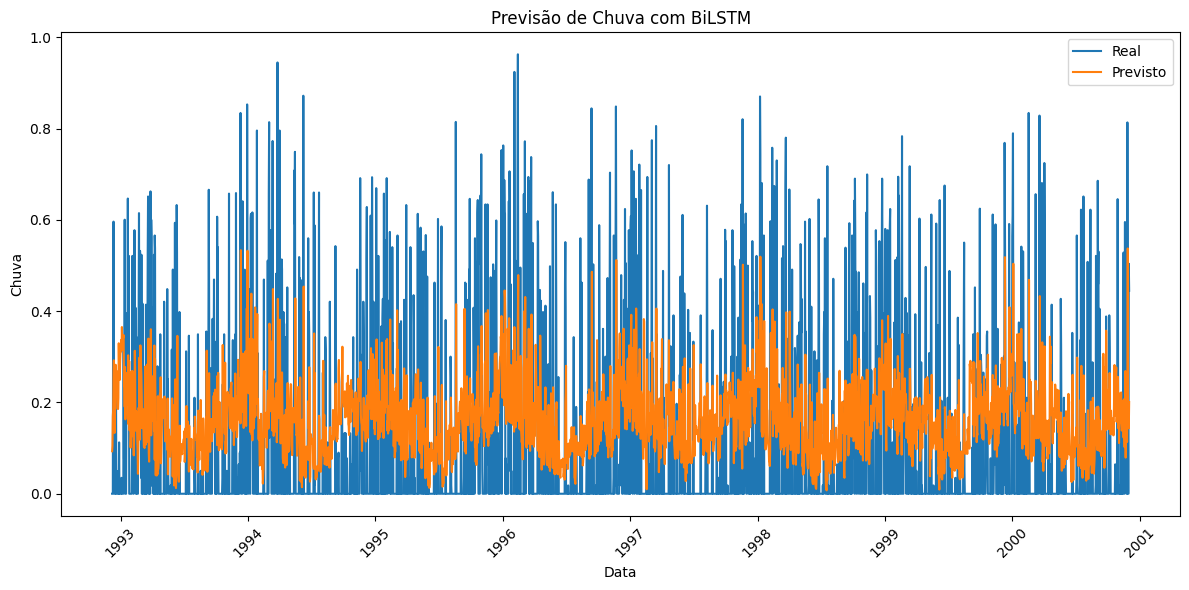

2025-10-13 22:13:40,363 - randomForest BRDWGD - INFO - Script BiLSTM BrDwgd(TensorFlow/Keras) finalizado.


In [14]:
logger.info("Gerando gráfico de previsão final.")
plt.figure(figsize=(12,6))
plt.plot(test_date, y_test, label="Real")
plt.plot(test_date, y_pred, label="Previsto")
plt.legend()
plt.title("Previsão de Chuva com BiLSTM")
plt.xlabel("Data")
plt.ylabel("Chuva")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
logger.info("Script BiLSTM BrDwgd(TensorFlow/Keras) finalizado.")